In [1]:
from __future__ import print_function
from __future__ import absolute_import
from infogan.misc.distributions import Uniform, Categorical, Gaussian, MeanBernoulli


import tensorflow as tf
import os
from infogan.misc.datasets import Dataset, MnistDataset
from infogan.models.regularized_gan import RegularizedGAN
from infogan.algos.infogan_trainer import InfoGANTrainer
from infogan.misc.utils import mkdir_p
import dateutil
import dateutil.tz
import datetime

import numpy as np

FFMPEG_BIN = 'ffmpeg'

In [2]:
%matplotlib inline

In [3]:
def ParitionData(images):
    num_total_inputs = len(images)

    train_images = images[0:num_total_inputs*6/10]
    cv_images    = images[num_total_inputs*6/10:num_total_inputs*8/10]
    test_images  = images[num_total_inputs*8/10:]
    
    return train_images, cv_images, test_images
def normalize(x):
    mu = np.mean(x)
    sigma = np.std(x)
    x_norm = (x - mu) / sigma  # All element-wise
    return x_norm


In [4]:
class SpeechFramesDataset(object):
    def __init__(self, video_file, image_width, image_height, image_depth = 1):
        self.frame_width  = image_width
        self.frame_height = image_height
        self.frame_depth  = image_depth # (number of colors)
        self.image_shape = (self.frame_height, self.frame_width, self.frame_depth)
        self.image_dim = self.frame_height * self.frame_width * self.frame_depth

        self.raw_images = self._load_frames(video_file)
        self.normalized_images = [normalize(x) for x in self.raw_images]
        train_images, cv_images, test_images = ParitionData(self.normalized_images)

        self.train = Dataset(np.asarray(train_images))
        self.validation = Dataset(np.asarray(cv_images))
        self.test = Dataset(np.asarray(test_images))
        
    def _open_video_pipe(self, video_file):
        import subprocess as sp
        pix_fmt = ''
        if self.frame_depth == 1:   pix_fmt = 'gray'
        elif self.frame_depth == 3: pix_fmt = 'rgb'
        else:                       raise "Bad image_depth"
        command = [ FFMPEG_BIN,
            '-i', video_file,
            '-f', 'image2pipe',
            '-pix_fmt', pix_fmt,
            '-s', '{0}x{1}'.format(self.frame_width, self.frame_height), # -s 1280x960
            '-vcodec', 'rawvideo', '-']
        self.video_pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)

    def _load_frames(self, video_file):
        ''' Import the movie file into a python array of images. '''
        self._open_video_pipe(video_file)
        self.frames = []
        while self.video_pipe:
            # read 1 frame bytes
            raw_image = self.video_pipe.stdout.read(self.image_dim)
            if not raw_image:
                break
            # transform the byte read into a numpy array
            image =  np.fromstring(raw_image, dtype='uint8')
            if np.isnan(np.sum(image)):
                raise Exception, "raw_image contained NaN!!: "+str(raw_image)
            #image = image.reshape(frame_dim)
            self.frames.append(image)
            # throw away the data in the pipe's buffer.
            self.video_pipe.stdout.flush()
        self.video_pipe = None
        return self.frames
    
    def transform(self, data):
        return data

    def inverse_transform(self, data):
        return data


In [5]:
root_log_dir = "logs/speech_face"
root_checkpoint_dir = "ckt/speech_face"
batch_size = 128
updates_per_epoch = 50    # How often to run the logging.
checkpoint_snapshot_interval = 1000  # Save a snapshot of the model every __ updates.
max_epoch = 200

In [6]:
# For now, copy the "C.3 CelebA" input settings:
# "For this task, we use 10 ten-dimensional categorical code and 128 noise variables, resulting in a concatenated dimension of 228.."
c3_celebA_latent_spec = [
    (Uniform(128), False),  # Noise
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
]
c3_celebA_image_size = 32

# For now, copy the "C.4 Faces" input settings:
# "For this task, we use 5 continuous latent codes and 128 noise variables, so the input to the generator has dimension 133."
c4_faces_latent_spec = [
    (Uniform(128), False),  # Noise
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
]
c3_faces_image_size = 32

# Trying with the mnist latent_spec.
c1_mnist_latent_spec = [
    (Uniform(62), False),
    (Categorical(10), True),
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
]
c3_mnist_image_size = 28

In [7]:
grayscale = 1
color = 3
dataset = SpeechFramesDataset('../fareeds_take.2015.09.21.speech.full_res.crop.048x054.mov',
                              c3_celebA_image_size, c3_celebA_image_size, grayscale)
#dataset = MnistDataset()

In [8]:
model = RegularizedGAN(
    output_dist=MeanBernoulli(dataset.image_dim),
    latent_spec=c3_celebA_latent_spec,  # For now, trying with the mnist latent_spec.
    batch_size=batch_size,
    image_shape=dataset.image_shape,
    # Trying with my new celebA network!
    network_type="celebA",
)

In [9]:
now = datetime.datetime.now(dateutil.tz.tzlocal())
timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
exp_name = "mnist_model_mnist_codes_normalized_fareed_%s" % timestamp

log_dir = os.path.join(root_log_dir, exp_name)
checkpoint_dir = os.path.join(root_checkpoint_dir, exp_name)

mkdir_p(log_dir)
mkdir_p(checkpoint_dir)

algo = InfoGANTrainer(
    model=model,
    dataset=dataset,
    batch_size=batch_size,
    exp_name=exp_name,
    log_dir=log_dir,
    checkpoint_dir=checkpoint_dir,
    max_epoch=max_epoch,
    updates_per_epoch=updates_per_epoch,
    snapshot_interval=checkpoint_snapshot_interval,
    info_reg_coeff=1.0,
    generator_learning_rate=1e-3,
    discriminator_learning_rate=2e-4,
)

In [10]:
# algo.visualize_all_factors()  # ... what does this do?

In [ ]:
sess = tf.Session()

algo.train(sess=sess)

In [37]:
tf_vars = tf.get_collection(tf.GraphKeys.VARIABLES)
pretty_vars = {v.name: v for v in tf_vars}
dict(pretty_vars.items()[:5])

{u'beta2_power_1:0': <tensorflow.python.ops.variables.Variable at 0x11d314f90>,
 u'g_net/custom_deconv2d_1/custom_deconv2d_1/biases/Adam:0': <tensorflow.python.ops.variables.Variable at 0x11ef37650>,
 u'g_net/fc_batch_norm/batch_norm/beta:0': <tensorflow.python.ops.variables.Variable at 0x116dbf110>,
 u'model/conv_batch_norm/conv_batch_norm/model/conv_batch_norm/conv_batch_norm/moments/normalize/mean/ExponentialMovingAverage:0': <tensorflow.python.ops.variables.Variable at 0x11f27d3d0>,
 u'model/fc_batch_norm/batch_norm/model/fc_batch_norm/batch_norm/moments/normalize/variance/ExponentialMovingAverage:0': <tensorflow.python.ops.variables.Variable at 0x11f0cdad0>}

In [38]:
import math
import numpy

In [39]:
tf_var_vals = {v.name : sess.run(v) for v in tf_vars}

In [42]:
non_nans = {name : v for name,v in tf_var_vals.iteritems() if not np.any(np.isnan(v))}
non_nans

{u'beta1_power:0': 0.0,
 u'beta1_power_1:0': 0.0,
 u'beta2_power:0': 0.49591962,
 u'beta2_power_1:0': 0.49591962,
 u'conv_batch_norm_2/conv_batch_norm/conv_batch_norm_2/conv_batch_norm/moments/normalize/mean/ExponentialMovingAverage:0': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 u'conv_batch_norm_2/conv_b

(28, 28, 1)


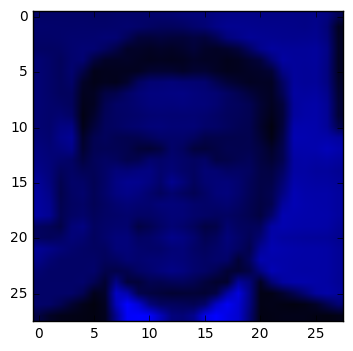

In [13]:
def play_frames_clip(frames):
    ''' frames -- a list/array of np.array images. Plays all frames in the notebook as a clip.'''
    from matplotlib import pyplot as plt
    from IPython import display

    for frame in frames:
        plt.imshow(frame)
        display.display(plt.gcf())
        display.clear_output(wait=True)

play_frames_clip([np.insert(np.insert(frame.reshape(dataset.image_shape[0], dataset.image_shape[1], 1), 0, 2, axis=2), 0, 2, axis=2) for frame in dataset.raw_images[10:20]])
print(dataset.image_shape)

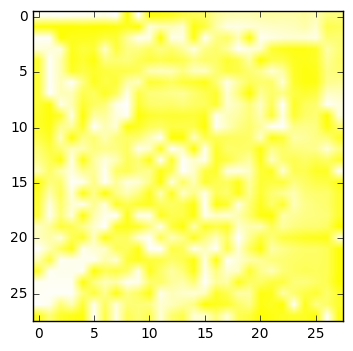

In [60]:
normalized_frames = [normalize(x) for x in dataset.raw_images[10:20]]
play_frames_clip([np.insert(np.insert(frame.reshape(dataset.image_shape[0], dataset.image_shape[1], 1), 0, 2, axis=2), 0, 2, axis=2) for frame in normalized_frames])


In [61]:
print(dataset.raw_images[0][:20])
print('--------------------')
print(dataset.train.images[0][:20])
print('--------------------')
print(normalize(dataset.train.images[0])[:20])

[102 103 104 104 103 101 101 103 106 104 105 108 111 116 117 120 130 135
 137 136]
--------------------
[-0.04355044 -0.04355044 -0.02038657 -0.04355044 -0.04355044 -0.06671431
 -0.08987818 -0.02038657  0.02594117 -0.02038657  0.02594117  0.07226891
  0.16492439  0.30390761  0.32707148  0.37339922  0.55871018  0.67452953
  0.6976934   0.6976934 ]
--------------------
[-0.04355044 -0.04355044 -0.02038657 -0.04355044 -0.04355044 -0.06671431
 -0.08987818 -0.02038657  0.02594117 -0.02038657  0.02594117  0.07226891
  0.16492439  0.30390761  0.32707148  0.37339922  0.55871018  0.67452953
  0.6976934   0.6976934 ]
